<a href="https://colab.research.google.com/github/Reptilefury/coursera-machine-learning/blob/main/Plant_disease_Detection_Plant_Village_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model ,Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
!pip install -Uqq opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/emmarex/plantdisease/download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: reptilefury
Your Kaggle Key: ··········


100%|██████████| 658M/658M [00:09<00:00, 76.6MB/s]


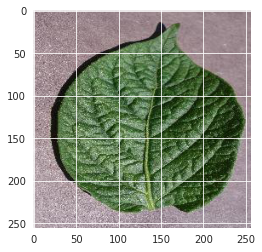

In [ ]:
fpath = "/content/plantdisease/PlantVillage/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG"
image = plt.imread(fpath)
image.shape
plt.imshow(image)

In [ ]:
#Iterate through the dataset directory and create a dataframe of the form filepaths and labels 
sdir = "/content/plantdisease/PlantVillage"
classlist = os.listdir(sdir)
filepaths = []
labels = []
for klass in classlist:
  classpath = os.path.join(sdir, klass)
  if os.path.isdir(classpath):
    flist = os.listdir(classpath)
    for f in flist:
      fpath = os.path.join(classpath,f)
      filepaths.append(fpath)
      labels.append(klass)
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
df = pd.concat([Fseries,Lseries], axis = 1)

In [ ]:
df.head()

,filepaths,labels
0,/content/plantdisease/PlantVillage/Tomato__Tom...,Tomato__Tomato_mosaic_virus
1,/content/plantdisease/PlantVillage/Tomato__Tom...,Tomato__Tomato_mosaic_virus
2,/content/plantdisease/PlantVillage/Tomato__Tom...,Tomato__Tomato_mosaic_virus
3,/content/plantdisease/PlantVillage/Tomato__Tom...,Tomato__Tomato_mosaic_virus
4,/content/plantdisease/PlantVillage/Tomato__Tom...,Tomato__Tomato_mosaic_virus


In [ ]:
len(df)

20639

In [ ]:
df['labels'].value_counts()

Tomato__Tomato_YellowLeaf__Curl_Virus          3209
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Pepper__bell___healthy                         1478
Tomato__Target_Spot                            1404
Tomato_Early_blight                            1000
Potato___Late_blight                           1000
Potato___Early_blight                          1000
Pepper__bell___Bacterial_spot                   997
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Potato___healthy                                152
Name: labels, dtype: int64

In [ ]:
sample_list=[]
max_size= 500
groups=df.groupby('labels')
for label in df['labels'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)

In [ ]:
working_dir = './'
aug_dir = os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
  shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in  df['labels'].unique():
  dir_path = os.path.join(aug_dir, label)
  os.mkdir(dir_path) 

In [ ]:
#Create augmented images and  store in augmented directories
target = 500
gen = ImageDataGenerator(horizontal_flip=True,rotation_range = 20, width_shift_range=.2, height_shift_range=.2,zoom_range=.2)

In [ ]:
groups = df.groupby('labels')
for label in df['labels'].unique():
  group = groups.get_group(label)
  sample_count = len(group)
  if sample_count<target:
    aug_count_img = 0
    delta = target - sample_count
    target_dir =  os.path.join(aug_dir, label)

    aug_gen = gen.flow_from_dataframe(group, x_col="filepaths",y_col=None, target_size=(224,224),class_mode=None, batch_size=1,shuffle=False,save_to_dir=target_dir,save_prefix='aug-', save_format='jpg')

Found 373 validated image filenames.
Found 152 validated image filenames.


In [ ]:
while aug_count_img<delta:
  images = next(aug_gen)
  aug_count_img += len(images)


In [ ]:
aug = r'./aug'
auglist = os.listdir(aug)
for klass in auglist:
  classpath = os.path.join(aug,klass)
  flist = os.listdir(classpath)  

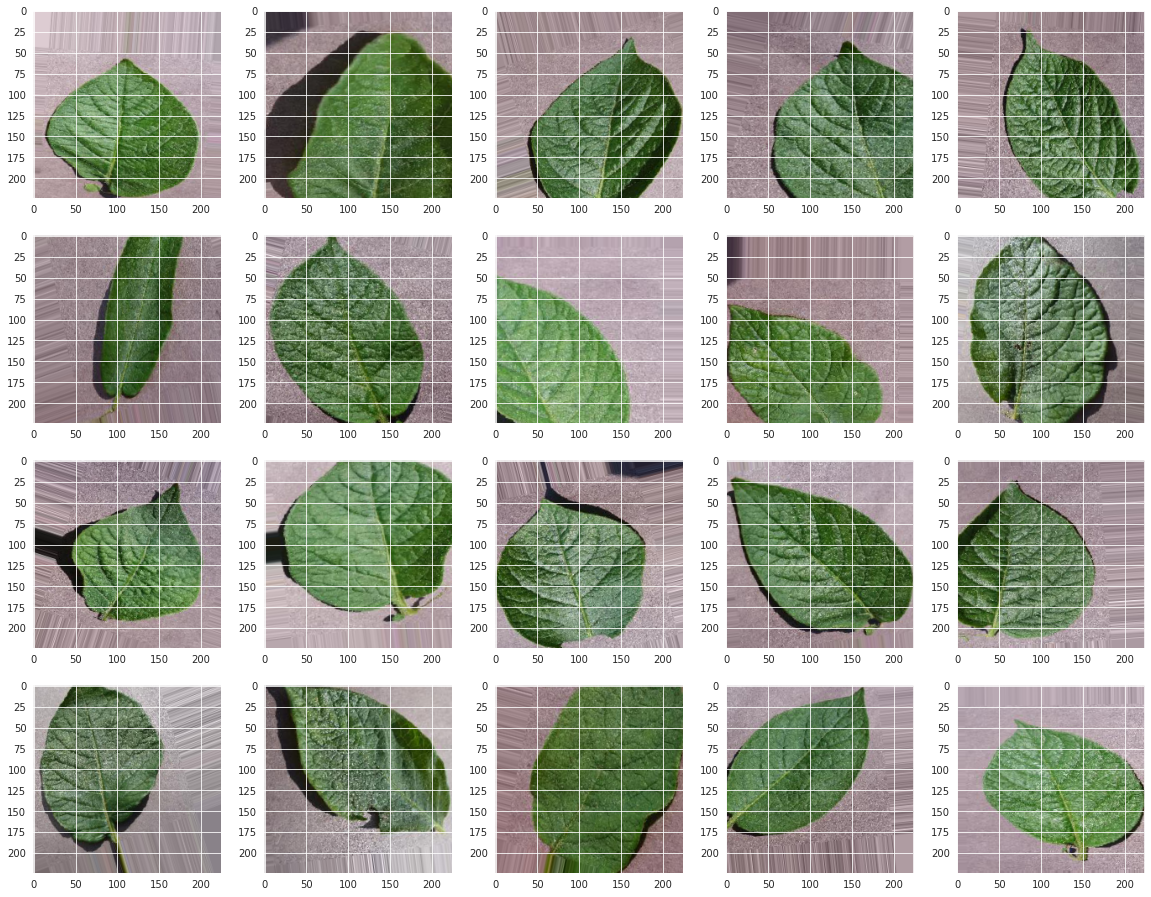

In [ ]:
plt.figure(figsize=(20,20))
for i in range(20):
  image = next(aug_gen)/255
  image = np.squeeze(image,axis = 0)
  plt.subplot(5,5, i+1)
  plt.imshow(image)

In [ ]:
#Create aux_df and concatenate 